In [17]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import cv2

In [18]:
class GANdataGenerator(Dataset):
    def __init__(self, data_dir, data_files, image_size):
        super(GANdataGenerator, self).__init__()
        self.data_dir = data_dir
        self.data = data_files
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data_file = self.data[index]
        data_file = os.path.join(self.data_dir, data_file)
        # print("Reading image from:", data_file)  # Print the image file path
        img_bgr = cv2.imread(data_file)
        if img_bgr is None:
            print("Error: Image file not found or cannot be opened.")
            return None
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_tensor = self.transform(img_rgb)
        
        return img_tensor


In [19]:
data_dir = 'data1'
random_people_images = os.listdir(os.path.join(data_dir, "RandomDataMasked"))
elon_musk_images = os.listdir(os.path.join(data_dir, 'MaskData'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
len(elon_musk_images)

1023

In [21]:
len(random_people_images)

5126

In [22]:
random_people_set = GANdataGenerator(data_dir=os.path.join(data_dir, 'RandomDataMasked'),
                                     data_files=random_people_images,
                                     image_size=128)

elon_musk_set = GANdataGenerator(data_dir=os.path.join(data_dir, 'MaskData'),
                                  data_files=elon_musk_images,
                                  image_size=128)

In [23]:
random_people_dataloader = DataLoader(random_people_set, batch_size=16, shuffle=True, num_workers=0)
elon_musk_dataloader = DataLoader(elon_musk_set, batch_size=16, shuffle=True, num_workers=0)

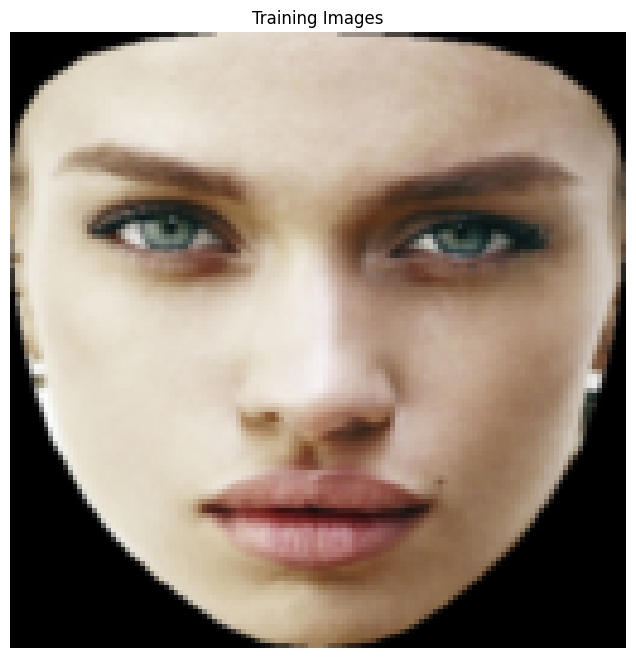

In [24]:
import torchvision.utils as vutils
import numpy as np
from matplotlib import pyplot as plt
real_batch = next(iter(random_people_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [25]:
import torch.nn as nn

# Define the conv block for the discriminator
def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    ]
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim  # Define conv_dim
        self.conv1 = conv_block(3, conv_dim, batch_norm=False)  # 3 channels for RGB images
        self.conv2 = conv_block(conv_dim, conv_dim*2)
        self.conv3 = conv_block(conv_dim*2, conv_dim*4)
        self.conv4 = conv_block(conv_dim*4, conv_dim*8)
        self.fc = nn.Linear(conv_dim*8*8*8, 1)  # Assuming input image size is 128x128
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, self.conv_dim*8*8*8)  # Use self.conv_dim here
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Define the generator
class Generator(nn.Module):
    def __init__(self, conv_dim=64):
        super(Generator, self).__init__()
        self.conv1 = conv_block(3, conv_dim, kernel_size=7, stride=1, padding=3, batch_norm=False)
        self.conv2 = conv_block(conv_dim, conv_dim*2)
        self.conv3 = conv_block(conv_dim*2, conv_dim*4)
        self.conv4 = conv_block(conv_dim*4, conv_dim*8)
        self.conv5 = conv_block(conv_dim*8, conv_dim*8)
        self.conv6 = conv_block(conv_dim*8, conv_dim*8)
        self.conv7 = conv_block(conv_dim*8, conv_dim*8)
        self.conv8 = conv_block(conv_dim*8, conv_dim*8, batch_norm=False)
        self.deconv1 = nn.ConvTranspose2d(conv_dim*8, conv_dim*8, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(conv_dim*8*2, conv_dim*8, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(conv_dim*8*2, conv_dim*8, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(conv_dim*8*2, conv_dim*8, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(conv_dim*8*2, conv_dim*4, kernel_size=4, stride=2, padding=1)
        self.deconv6 = nn.ConvTranspose2d(conv_dim*4*2, conv_dim*2, kernel_size=4, stride=2, padding=1)
        self.deconv7 = nn.ConvTranspose2d(conv_dim*2*2, conv_dim, kernel_size=4, stride=2, padding=1)
        self.deconv8 = nn.ConvTranspose2d(conv_dim*2, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x7 = self.conv7(x6)
        x8 = self.conv8(x7)
        x9 = self.deconv1(x8)
        x9 = torch.cat((x9, x7), dim=1)
        x10 = self.deconv2(x9)
        x10 = torch.cat((x10, x6), dim=1)
        x11 = self.deconv3(x10)
        x11 = torch.cat((x11, x5), dim=1)
        x12 = self.deconv4(x11)
        x12 = torch.cat((x12, x4), dim=1)
        x13 = self.deconv5(x12)
        x13 = torch.cat((x13, x3), dim=1)
        x14 = self.deconv6(x13)
        x14 = torch.cat((x14, x2), dim=1)
        x15 = self.deconv7(x14)
        x15 = torch.cat((x15, x1), dim=1)
        x16 = self.deconv8(x15)
        return x16

# Define the CycleGAN model
class CycleGAN(nn.Module):
    def __init__(self, G_XtoY, G_YtoX, D_X, D_Y):
        super(CycleGAN, self).__init__()
        self.G_XtoY = G_XtoY
        self.G_YtoX = G_YtoX
        self.D_X = D_X
        self.D_Y = D_Y


In [26]:
# Define loss functions
def real_mse_loss(D_out):
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    return lambda_weight * torch.mean(torch.abs(real_im - reconstructed_im))

def identity_loss(real_im, identity_im, lambda_weight):
    return lambda_weight * torch.mean(torch.abs(real_im - identity_im))

In [27]:
# Create the CycleGAN model
G_XtoY = Generator()
G_YtoX = Generator()
D_X = Discriminator()
D_Y = Discriminator()
cycle_gan = CycleGAN(G_XtoY, G_YtoX, D_X, D_Y)

In [28]:

cycle_gan.to(device)

CycleGAN(
  (G_XtoY): Generator(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace

In [29]:
# Define optimizers
g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())
d_x_params = list(D_X.parameters())
d_y_params = list(D_Y.parameters())
g_optimizer = torch.optim.Adam(g_params, lr=0.0002, betas=(0.5, 0.999))
d_x_optimizer = torch.optim.Adam(d_x_params, lr=0.0002, betas=(0.5, 0.999))
d_y_optimizer = torch.optim.Adam(d_y_params, lr=0.0002, betas=(0.5, 0.999))

In [30]:
# Training loop
def train_cycle_gan(cycle_gan, dataloader_X, dataloader_Y, device, num_epochs=100):
    for epoch in range(num_epochs):
        for real_X, real_Y in zip(dataloader_X, dataloader_Y):
            # Move images to the desired device
            real_X = real_X.to(device)
            real_Y = real_Y.to(device)
            
            ### Discriminator training ###
            d_x_optimizer.zero_grad()
            d_y_optimizer.zero_grad()
            
            # Generate fake images
            fake_X = cycle_gan.G_YtoX(real_Y)
            fake_Y = cycle_gan.G_XtoY(real_X)
            
            # Discriminator X loss
            d_x_real_loss = real_mse_loss(cycle_gan.D_X(real_X))
            d_x_fake_loss = fake_mse_loss(cycle_gan.D_X(fake_X))
            d_x_loss = d_x_real_loss + d_x_fake_loss
            
            # Discriminator Y loss
            d_y_real_loss = real_mse_loss(cycle_gan.D_Y(real_Y))
            d_y_fake_loss = fake_mse_loss(cycle_gan.D_Y(fake_Y))
            d_y_loss = d_y_real_loss + d_y_fake_loss
            
            d_x_loss.backward()
            d_x_optimizer.step()
            d_y_loss.backward()
            d_y_optimizer.step()
            
            ### Generator training ###
            g_optimizer.zero_grad()
            
            # Identity losses
            identity_loss_X = identity_loss(real_X, cycle_gan.G_YtoX(real_X), lambda_weight=10)
            identity_loss_Y = identity_loss(real_Y, cycle_gan.G_XtoY(real_Y), lambda_weight=10)
            
            # Adversarial losses
            adversarial_loss_X = real_mse_loss(cycle_gan.D_X(fake_X))
            adversarial_loss_Y = real_mse_loss(cycle_gan.D_Y(fake_Y))
            
            # Cycle consistency losses
            cycle_consistency_loss_X = cycle_consistency_loss(real_X, cycle_gan.G_YtoX(fake_Y), lambda_weight=10)
            cycle_consistency_loss_Y = cycle_consistency_loss(real_Y, cycle_gan.G_XtoY(fake_X), lambda_weight=10)
            
            # Total generators' losses
            total_loss_X = adversarial_loss_X + cycle_consistency_loss_X + identity_loss_X
            total_loss_Y = adversarial_loss_Y + cycle_consistency_loss_Y + identity_loss_Y
            
            total_loss_X.backward()
            total_loss_Y.backward()
            g_optimizer.step()
        
        # Print the log info
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'D_X_loss: {d_x_loss.item():.4f}, '
              f'D_Y_loss: {d_y_loss.item():.4f}, '
              f'G_total_loss_X: {total_loss_X.item():.4f}, '
              f'G_total_loss_Y: {total_loss_Y.item():.4f}')

In [31]:
torch.cuda.empty_cache()

In [32]:
# Train the CycleGAN
train_cycle_gan(cycle_gan, random_people_dataloader, elon_musk_dataloader, device, num_epochs=10)

e:\personal\DL_Project\newenv\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
e:\personal\DL_Project\newenv\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU  (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
e:\personal\DL_Project\newenv\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed w

RuntimeError: The size of tensor a (128) must match the size of tensor b (256) at non-singleton dimension 3

In [ ]:
import torch

print(torch.cuda.is_available())  # Should print True if CUDA is available
print(torch.version.cuda)         # Should print the CUDA version


True
11.8
